##  1. Load Data and Modules 

In [1]:
import sys,os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import re
import researchpy as rp
import datetime
from itertools import combinations 
from scipy import stats
plt.style.use('seaborn-pastel')
pd.set_option('display.max_colwidth', -1)

In [2]:
root = sys.path[0]
data_dir = os.path.join(root, '../data')
dict_dir = os.path.join(root, '../docs')

In [3]:
# loan csv files and add one column that indicates when data is achieved 
dt = []
info = ['2016Q1','2016Q2','2016Q3','2016Q4','2017Q1','2017Q2','2017Q3','2017Q4']
for idx in info: 
    file = "{}.csv.gz".format(idx)
    temp = pd.read_csv(os.path.join(data_dir, file) , compression='gzip', error_bad_lines=False, index_col=0,low_memory=False)
    dt.append(temp)

In [4]:
data = pd.concat(dt, axis=0, ignore_index=True)

In [5]:
# import data dictionary 
browse_notes = pd.read_excel( os.path.join( dict_dir, 'data_dictionary.xlsx'),sheet_name= 'browseNotes')
loan_stats = pd.read_excel( os.path.join( dict_dir, 'data_dictionary.xlsx'),sheet_name= 'LoanStats')

## 2. Data 

In [6]:
nRow, nCol = data.shape
print('There are {} rows and {} columns'.format(nRow, nCol)) 

There are 877986 rows and 151 columns


In [7]:
display(data.sample(5)) 

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
868153,120323668,NaN,24000,24000,24000.0,60 months,11.99%,533.75,B,B5,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
159603,79493411,NaN,10000,10000,10000.0,36 months,11.47%,329.62,B,B5,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
667596,118237350,NaN,10000,10000,10000.0,60 months,20.00%,264.94,D,D4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
522861,96352201,NaN,10000,10000,10000.0,36 months,7.24%,309.87,A,A3,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
563940,110366776,NaN,6000,6000,6000.0,36 months,24.85%,238.09,E,E3,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


## 3. Target 
- There are seven types of loan statuses. Four of these are indeed associated with ongoing loans. 
- Although the status like *late(31-120 days)* might indicate the investment has go sour, it's still hard to tell the loan will turn into default or not until reach the final stage
- So I trim the dataset and  only keeps loans that have reached maturity, that are those in status of 'Fully Paid','Default', 'Charged Off'. And consider loan with status 'Fully Paid' as *Non-default* loans, with'Default' &  'Charged Off' as *Default loans*.

In [8]:
meaning = [
"Loan is up to date on current payments.",
"Loan has been fully paid off.",
"Loan for which there is no longer a reasonable expectation of further payments.",
"Loan hasn’t been paid in 31 to 120 days (late on the current payment).",
"The loan is past due but still in the grace period of 15 days.",
"Loan hasn't been paid in 16 to 30 days (late on the current payment).",
"Loan is defaulted on and no payment has been made for more than 121 days."]
status, count = data['loan_status'].value_counts().index, data['loan_status'].value_counts().values
loan_statuses_explanation = pd.DataFrame({'Loan Status': status,'Count': count,'Meaning': meaning})
loan_statuses_explanation

,Loan Status,Count,Meaning
0,Current,503359,Loan is up to date on current payments.
1,Fully Paid,264241,Loan has been fully paid off.
2,Charged Off,80804,Loan for which there is no longer a reasonable expectation of further payments.
3,Late (31-120 days),16259,Loan hasn’t been paid in 31 to 120 days (late on the current payment).
4,In Grace Period,8052,The loan is past due but still in the grace period of 15 days.
5,Late (16-30 days),4505,Loan hasn't been paid in 16 to 30 days (late on the current payment).
6,Default,766,Loan is defaulted on and no payment has been made for more than 121 days.


In [9]:
# Trim data to contain these reached maturity
df = data[data.loan_status.isin(['Fully Paid','Default', 'Charged Off'])].copy()
# 0: loan is not default; 1: loan is default 
target = np.where(df.loan_status == 'Fully Paid', 0, 1) 
df['default'] = target
loan_status_dist = df['default'].value_counts(normalize=True)*100
loan_status_dist

0    76.411971
1    23.588029
Name: default, dtype: float64

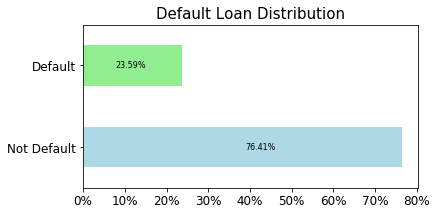

In [10]:
loan_status_dist = df['default'].value_counts(normalize=True) * 100
ax= loan_status_dist.plot(kind='barh', figsize=(6,3),fontsize=12, rot = 0, color =['lightblue', 'lightgreen'] )
plt.figtext(0.2, 0.68, str(loan_status_dist[1].round(2))+'%', fontsize=8)
plt.figtext(0.5, 0.3, str(loan_status_dist[0].round(2))+'%', fontsize=8)
plt.title('Default Loan Distribution', fontsize = 15)
ax.xaxis.set_major_formatter(mtick.PercentFormatter())
ax.set_yticklabels(['Not Default','Default'])
plt.show()

## 4. Feature Selection
#### Select attributes  that are accessible to investors by the time they choosing notes
- When investors are browsing the notes, they can filter notes based on some attributes, and these attributes are recorded in the 'Browse Notes' in data dictionary. *For more info on browse note, check the posting [here](https://blog.lendingclub.com/expanded-credit-att/) and [here](https://www.lendingclub.com/public/browseNotesHelp.action)*
- The dataset contains 150 fields, but not all of them are included in browse note, so I only need to use these attributes that appear in both loanstats and browsenotes, as these are the ones that are accessible to investors at the time they pick notes

In [11]:
# detect attributes that investors are not able to browse, and save them in the array "not_avail_to_investor"
browse_notes_fileds = browse_notes['BrowseNotesFile'].dropna()
browse_notes_fileds_reg = [x.replace("_", "").strip().lower() for x in browse_notes_fileds.tolist()]
loan_fileds_reg=[x.replace("_", "").lower() for x in df.columns.values.tolist()]
not_avail_to_investor = np.setdiff1d(loan_fileds_reg, browse_notes_fileds_reg)

In [12]:
# remove attributes in loan_status that are not available to investors and add back some fields  
not_avail_to_investor_indx = np.where(np.isin(loan_fileds_reg, not_avail_to_investor))
predictors = np.delete(df.columns.values,not_avail_to_investor_indx).tolist() 

In [13]:
# double checking these fields, I found some fields are named differently in browsenotes, but they have the same description,
# for example "mths_since_recent_inq" is named as "mthsSinceMostRecentInq" in browsenotes 
# so I manually added these fields back to predictors set 
manual_add  = ['verification_status', 'mths_since_recent_inq', 'mo_sin_old_il_acct',
           'mths_since_recent_bc_dlq','verification_status_joint' ]
predictors += manual_add

In [14]:
df_2 = df[predictors + ['default']].copy()

## 5. Analyze Predictors  by Categories
**Due to large amount of variables, I first divided them into different categories and analyze them one by one**
- loan related
    - loan characteristics
    - second application 
- borrower related 
    - borrower characteristics
    - borrower indebtness 
    - current financial situation and credit history 
    - borrower assessment 

In [15]:
l_charct = ['earliest_cr_line','application_type', 'desc','funded_amnt','id', 'initial_list_status', 'installment', 
           'loan_amnt', 'member_id', 'purpose', 'term', 'title','url']

In [16]:
r = re.compile("^sec_.*|.*_joint$")
sec_app = list(filter(r.match, df_2.columns.values.tolist()))

In [17]:
b_asses = ['fico_range_high', 'fico_range_low','grade','int_rate','sub_grade']
b_charct = ['addr_state','annual_inc', 'emp_length','emp_title', 'home_ownership','verification_status','zip_code']
b_indebt = ['dti']

In [18]:
dep_var = ['default']
b_fin = list(set(df_2.columns.values.tolist()).difference(set(dep_var + l_charct +b_asses + b_charct + b_indebt +sec_app)))

#### Create missing value check and  plot functions

In [19]:
def miss_value_table(dt):
    '''
    miss_value_table: return a table that contains variables with their number of missing values and missing rate
    '''
    miss_val_cnt = dt.isnull().sum()
    miss_val_pct = dt.isnull().sum()/len(dt)*100
    miss_val_table  = pd.concat([miss_val_cnt,miss_val_pct],axis =1 )
    miss_val_table.columns = ['Num_of_missing', "Pect_of_missing"]
    miss_val_table_sec = miss_val_table.loc[miss_val_table['Num_of_missing']!=0,:].sort_values(by=['Num_of_missing'], ascending = False)
    return miss_val_table_sec

In [20]:
def univariate_plot(df,pred,predtype):
    
    '''
    univariate_plot: 
            if Continuos('cont') : returns Distribution & Boxplot 
            if Categorical('cat') : Countplot will be plotted   
    '''
    fig, ax=plt.subplots(nrows =1,ncols=2,figsize = (8,4) )
    
    if predtype == 'cont':
        sns.distplot(df[pred],ax=ax[0])
    else:
        sns.countplot(df[pred],ax=ax[0] ) 
        labels = df[pred].unique().tolist()
        if len(labels) > 4:
            ax[0].set_xticklabels(labels, rotation=90) 
    ax[0].set_ylabel('Count')
    ax[0].set_title("{} Distribution".format(pred))
    
    
    if predtype == 'cont':
        sns.boxplot(data = df, x=pred,orient='v',ax = ax[1])
    else:
        cnt_df = (df.groupby([pred])['default'].value_counts(normalize = True).rename('Percent').reset_index() )
        cnt_df_f = cnt_df[cnt_df.default==1]
        #p = plt.figure(figsize=(6,4))   
        sns.barplot(x= pred,y = 'Percent', data= cnt_df_f, ax = ax[1])
       
        labels = cnt_df_f[pred].tolist()
        if len(labels) > 4:
            ax[1].set_xticklabels(labels, rotation= 90) 
        else: 
            ax[1].set_xticklabels(labels) 
        
    ax[1].set_title("Fraction loan default by {}".format(pred))
    
    plt.tight_layout()  

In [21]:
def pred_by_default(df, pred, predtype ):
    if predtype == 'cat':
        default_by_pred = (df.groupby([pred])['default']
                     .value_counts(normalize=True)
                     .rename('cnt')
                    
                     .reset_index()     
                     .sort_values(['default','cnt'], ascending = [False, False]))
     
        p = sns.barplot(x=pred, y="cnt", hue="default", data=default_by_pred)
        if len(default_by_pred) > 5: 
            _ = plt.setp(p.get_xticklabels(), rotation=90)  # Rotate labels
            
        _ = plt.title("Default Rate,by {}".format(pred))
    
    if predtype == 'cont':
        p = sns.distplot(df[df['default'] == 1][pred], bins=20, hist=True, kde=True, color='blue')
        _ = sns.distplot(df[df['default'] == 0][pred], bins=20, hist=True, kde=True, color='red')
        _ = plt.title("Default Rate,by {}".format(pred))
        _ = plt.legend(['Default', 'Not Default'])

        
    return p

### 5.1  secondary application 
- The missing rate for variables related with secondary applicant is extremely high and some of them are of similar  missing rate. 
- I found there are two reasons causing this:
   1. These fields are related to joint application, so if it's a individual loan, then this filed is not applicable => systematic missing
   2. LC added 13 new features realted to joint application, and the fields will only apply for new joint application loans as of March 9, 2017 and going forward. => random missing due to broken data collection process
(*check [website](https://help.lendingclub.com/hc/en-us/articles/115004323368-Recent-and-upcoming-changes-to-the-downloadable-data-files-and-API-services) for more info*)

In [22]:
df_2.filter(sec_app).head(3)

,annual_inc_joint,dti_joint,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,verification_status_joint
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
# check missing 
miss_value_table( df_2.filter(sec_app))

,Num_of_missing,Pect_of_missing
sec_app_mths_since_last_major_derog,343207,99.246988
sec_app_revol_util,338706,97.945409
revol_bal_joint,338596,97.913600
sec_app_fico_range_low,338595,97.913311
sec_app_fico_range_high,338595,97.913311
sec_app_earliest_cr_line,338595,97.913311
sec_app_inq_last_6mths,338595,97.913311
sec_app_mort_acc,338595,97.913311
sec_app_open_acc,338595,97.913311
sec_app_open_act_il,338595,97.913311


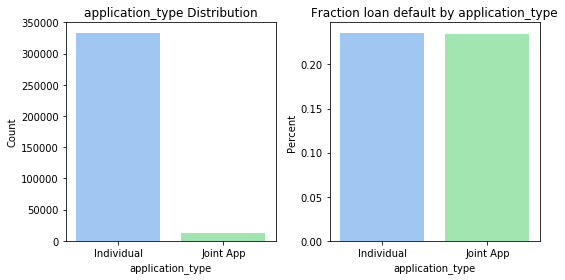

In [24]:
univariate_plot(df_2,'application_type' ,'cat')
plt.show()

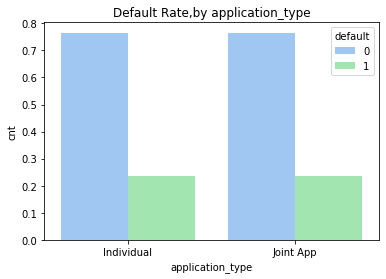

In [25]:
pred_by_default(df_2,'application_type','cat')
plt.show()

- The default rates for individual and joint application are alomost the same. 
- Large amount of missing rata and small amount of joint applications
- It's better to limit our  scope to individual loans only, and removed secondary applicants from the dataset along with all the variables in this category

In [26]:
df_3 = df_2[df_2.application_type == 'Individual'].drop(sec_app + ['application_type'], axis =1).copy()

### 5.2  loan characteristics
- After checking these variables, found some add no relevant information with regards to predicting default(**id, member id,url**) or contain substatial amount of missings(**desc**) or contains redundant info (**title**); therefore, I dropped these fiels
- **funded_amnt**: redundant, same as **loan_amnt**, so drop it 
- convert **earliest_cr_line** to datetime, create a new varible **days_since_earliest_cr** to compute number of days since the first create line, and drop the **earliest_cr_line**

In [27]:
df_3.filter(l_charct).head(3)

,earliest_cr_line,desc,funded_amnt,id,initial_list_status,installment,loan_amnt,member_id,purpose,term,title,url
0,Jun-05,NaN,8400,75910406,w,270.06,8400,NaN,debt_consolidation,36 months,Debt consolidation,https://lendingclub.com/browse/loanDetail.action?loan_id=75910406
4,Jun-01,NaN,20000,76003313,w,664.20,20000,NaN,debt_consolidation,36 months,Debt consolidation,https://lendingclub.com/browse/loanDetail.action?loan_id=76003313
5,Jul-05,NaN,13625,76083306,w,326.36,13625,NaN,credit_card,60 months,Credit card refinancing,https://lendingclub.com/browse/loanDetail.action?loan_id=76083306


In [28]:
# check missing 
miss_value_table(df_3.filter(l_charct))

,Num_of_missing,Pect_of_missing
member_id,333347,100.000000
desc,333330,99.994900
title,11982,3.594453


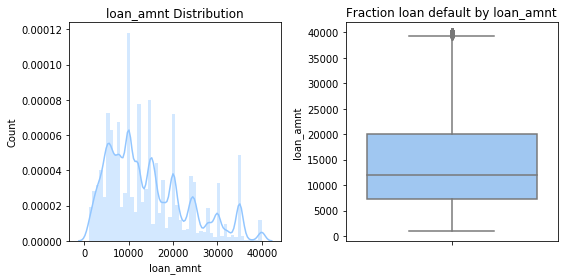

In [29]:
univariate_plot(df_3,'loan_amnt','cont') 

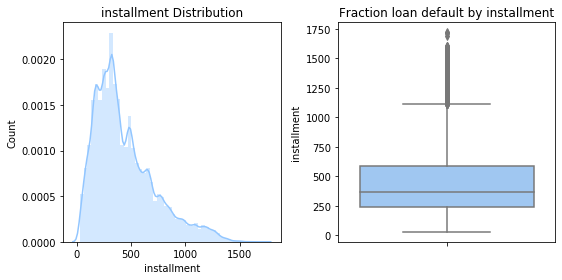

In [30]:
univariate_plot(df_3,'installment','cont') # substantial outliers  for installment 

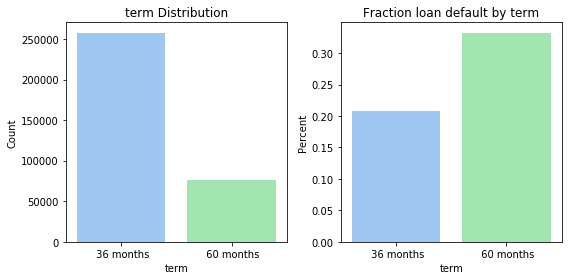

In [31]:
univariate_plot(df_3,'term','cat')  # most of loans are 3 year loan, while 5 - year loan has higher rate of default 

In [32]:
# all fund amount are equal to loan amount , so fund amount is redundant 
any(df_3.loan_amnt != df_3.funded_amnt)

False

In [33]:
# convert earliest_cr_line to datetime type 
# and create a new varible mths_since_earliest_cr 
dt = pd.to_datetime(df_3['earliest_cr_line'], format = "%b-%y")
dy = [d.year -100  if d.year > 2020 else d.year  for d in dt  ]
dm = [d.month for d in dt]
now = datetime.datetime.now()
num_of_mths = [ 12*(now.year - x )+ y  for x,y  in zip(dy, dm) ] 
df_3['mths_since_earliest_cr'] = num_of_mths

In [34]:
# the files contains white space, trim it 
df_3.term.unique()

array([' 36 months', ' 60 months'], dtype=object)

In [35]:
df_3.term = df_3.term.apply(lambda x: x.lstrip())

In [36]:
# drop unwanted fields 
df_4 = df_3.drop(['url','id','desc', 'member_id','title','funded_amnt','earliest_cr_line'], axis=1).copy()

### 5.3  borrower characteristics
- Only first 3 number of **zip code** is visible, it is also redundant as **addr_state** also convey Geographical info => consider to **drop zip code**
- The **emp_title** is provided by borrower, which contains 96649 different titles , out of which 21201 is missing； Due to the large number of job titles and the missing entries => drop ** emp_title**
- **emp length** has missing values, which might due to: 
    1. the person is  during unemployment
    2. the person is in employment, but didn't to fill this field 
    3. however, the default rate for the above two types doesn't differ too much; but both types have default rate (above 30%) that higher than the others in employment (on average at 22%)
So, encode **emp length**’s missing value to '0 year'
- **The default rate is  varies by state, add visulization plot to show**

In [37]:
df_4.filter(b_charct).head(3)

,addr_state,annual_inc,emp_length,emp_title,home_ownership,verification_status,zip_code
0,GA,66000.0,2 years,RV Tech,MORTGAGE,Not Verified,301xx
4,FL,49000.0,10+ years,rn case manager,MORTGAGE,Source Verified,321xx
5,IN,50000.0,1 year,Director of Sales & Marketing,MORTGAGE,Not Verified,476xx


In [38]:
miss_value_table(df_4.filter(b_charct))

,Num_of_missing,Pect_of_missing
emp_title,21201,6.360039
emp_length,20969,6.290442


In [39]:
print("Num of unique employment title: {}".format(len(df_4.emp_title.unique())))

Num of unique employment title: 96649


check the how default rate changes with different employment length 

In [40]:
typy_1 = df_4.default[df_4.emp_length.isnull()&df_4.emp_title.isnull()].value_counts(normalize = True).rename('Len: No & Title: No').reset_index(drop = True)
typy_2 = df_4.default[df_4.emp_length.isnull()&df_4.emp_title.notnull()].value_counts(normalize = True).rename('Len: No & Title: Yes').reset_index(drop = True)
typy_3 = df_4.default[df_4.emp_length.notnull()].value_counts(normalize = True).rename('Len: Yes').reset_index(drop = True)
s = pd.Series(['No','Yes'])
pd.concat([s.rename('Default'), typy_1, typy_2,typy_3], axis =1)

,Default,Len: No & Title: No,Len: No & Title: Yes,Len: Yes
0,No,0.671118,0.673203,0.770326
1,Yes,0.328882,0.326797,0.229674


In [41]:
df_4['emp_length'] = df_4['emp_length'].fillna('0 year')

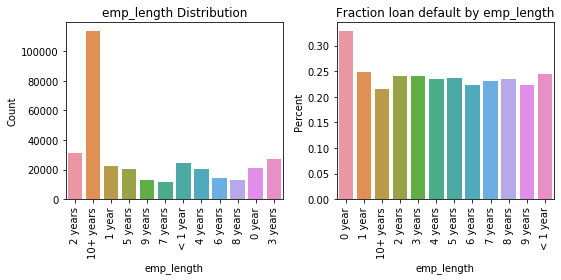

In [42]:
univariate_plot(df_4, 'emp_length', 'cat') # Most applicants have employment length >0 and unemployed have highest default rate

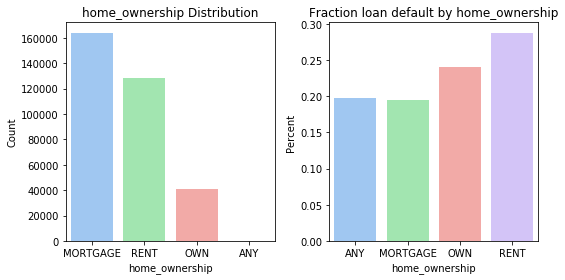

In [43]:
univariate_plot(df_4, 'home_ownership', 'cat') #renter has highest default rate

In [44]:
df_5 = df_4.drop(['zip_code', 'emp_title' ], axis =1).copy()

### 5.4  borrower indebtness - dti 
- this values is represented in ratio 
- no missing values, but contains one observation that has negative dti => drop this row 

In [45]:
df_5.dti.describe()

count    333347.000000
mean     18.242915    
std      8.521689     
min     -1.000000     
25%      11.860000    
50%      17.750000    
75%      24.310000    
max      49.960000    
Name: dti, dtype: float64

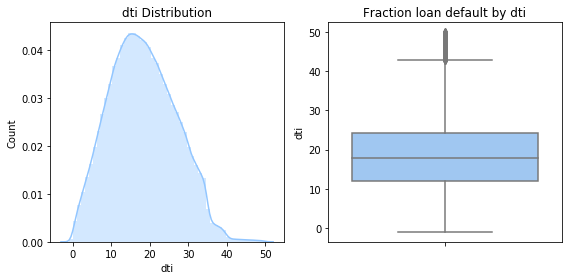

In [46]:
univariate_plot(df_5,'dti', 'cont') # outliers detected 

In [47]:
# dti is > = 0 , drop one case with negative dti 
df_5.drop( df_5[ df_5['dti']< 0 ].index , inplace=True)

### 5.5  borrower accessment
- these variables do no contain missing values
- convert **Interest rate** to number by strip the '%' sign 
- replace **fico_range_high** and  **fico_range_low** with a new variable **fico_range_avg** 

In [48]:
df_5.filter(b_asses).head(3)

,fico_range_high,fico_range_low,grade,int_rate,sub_grade
0,674,670,B,9.75%,B3
4,679,675,C,11.99%,C1
5,749,745,C,15.31%,C5


In [49]:
df_5.int_rate = df_5.int_rate.apply(lambda x: float(x.rstrip('%')))

In [50]:
df_5['fico_range_avg'] = df_5[['fico_range_high', 'fico_range_low']].mean(axis=1)

In [51]:
df_6 = df_5.drop(['fico_range_high', 'fico_range_low'], axis =1).copy()

In [52]:
b_asses_2  =  list( set(b_asses)  - set(['fico_range_high', 'fico_range_low']) )
b_asses_2.append('fico_range_avg')
df_6[b_asses_2].head(3)

,sub_grade,int_rate,grade,fico_range_avg
0,B3,9.75,B,672.0
4,C1,11.99,C,677.0
5,C5,15.31,C,747.0


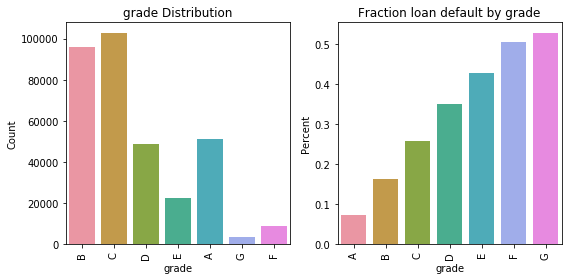

In [53]:
univariate_plot(df_6, 'grade','cat') 
# Most loan are of grade C ; Most of default loan are given type G, which indicates the rating system of LC is good 

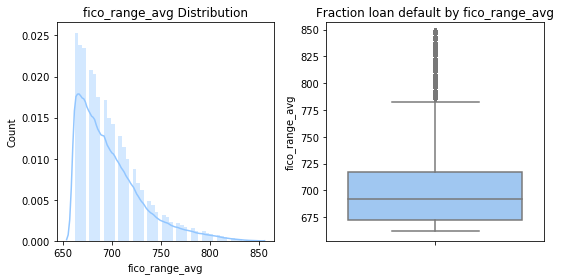

In [54]:
univariate_plot(df_6, 'fico_range_avg','cont') # outliers detected 

### 5.6 borrower financial situation
*il:installment accounts; rev/rv: revolving credit; bc: bankcard accounts;util: ratio of balance to credit limit*
- only 3 cases have missing fields **inq_last_6mths** or **avg_cur_bal**=> remove these 3 cases
- Variables with similar number of missings 
- Months since event variables
- **revol_util** should be convert to float type

In [55]:
df_6.filter(b_fin).head(3)

,percent_bc_gt_75,tot_cur_bal,num_bc_tl,num_rev_accts,mths_since_last_record,revol_util,open_acc,il_util,num_actv_bc_tl,num_tl_30dpd,...,open_act_il,total_bc_limit,delinq_amnt,total_bal_il,collections_12_mths_ex_med,mths_since_recent_bc_dlq,num_tl_90g_dpd_24m,disbursement_method,mths_since_rcnt_il,tot_coll_amt
0,100.0,157051,7,12,NaN,78.40%,7,91.0,2,0,...,1.0,6200,0,19231.0,1,NaN,0,Cash,10.0,0
4,100.0,125922,4,12,NaN,89.70%,8,87.0,2,0,...,1.0,13100,0,10623.0,0,NaN,0,Cash,34.0,0
5,11.1,204560,21,35,NaN,12.40%,21,86.0,2,0,...,4.0,66900,0,137787.0,0,NaN,0,Cash,8.0,0


In [56]:
mt = miss_value_table(df_6.filter(b_fin))
mt

,Num_of_missing,Pect_of_missing
mths_since_last_record,265642,79.689572
mths_since_recent_bc_dlq,250590,75.174143
mths_since_last_major_derog,236481,70.941604
mths_since_recent_revol_delinq,215701,64.707841
mths_since_last_delinq,160263,48.077073
il_util,42605,12.781014
mths_since_recent_inq,28745,8.623172
num_tl_120dpd_2m,16689,5.006510
mths_since_rcnt_il,8054,2.416108
mo_sin_old_il_acct,8026,2.407709


##### 5.6.1  Variables with similar number of missings
- These missing observations are all loans issued prior to January 2016, which is missing randomly, plus  due to broken data collection process 
- Plus, due to the small amount of missing, I **remove these observations from dataset** 

In [57]:
to_drop_row = mt[mt.Num_of_missing <= 32 ].index.tolist()
df_7= df_6.dropna(how='any', subset= to_drop_row,axis = 0).copy()

##### 5.6.2  Months since event variables
- These variables represent stating how many months ago an event occurred. 
- For instance, months since last delinquency, last record or most recent bank card account was opened. 
- They contain a lot of NA entries, which mean that the event has not occurred previously in the loan applicants record. This feature is considered as systematic missing, i.e. it's missing for a reason

**Take the variable'mths_since_last_record' as an example,  which measures how long it has been since last derogatory public record**

In [58]:
# if public record = 0, then 'mths_since_last_record' has missing value 
g = df_7.mths_since_last_record.isnull().groupby([df_7['pub_rec']]).sum().astype(int).reset_index(name = 'countna')
print( g.loc[g['countna'] != 0,:] ) 

   pub_rec  countna
0  0        265613 


In [59]:
# If one has no public record, then the default rate is around 23%, 
# With low values, say less than a year, the default rate is around 30%, 
# as the number of months inceases, the default rate decreases 
# So there is definitely some predict power in it 
c = df_7[df_7.pub_rec == 0].groupby(['default'])['default'].count()
print(c/sum(c))

default
0    0.769763
1    0.230237
Name: default, dtype: float64


In [60]:
df_7.groupby(pd.cut(df_7["mths_since_last_record"], [0, 12, 36, 60, 96, df_7["mths_since_last_record"].max()] ))['default']\
.value_counts(normalize=True)\
.rename('prop')\
.reset_index()

,mths_since_last_record,default,prop
0,"(0.0, 12.0]",0,0.697531
1,"(0.0, 12.0]",1,0.302469
2,"(12.0, 36.0]",0,0.734460
3,"(12.0, 36.0]",1,0.265540
4,"(36.0, 60.0]",0,0.747059
5,"(36.0, 60.0]",1,0.252941
6,"(60.0, 96.0]",0,0.744664
7,"(60.0, 96.0]",1,0.255336
8,"(96.0, 121.0]",0,0.733654
9,"(96.0, 121.0]",1,0.266346


In [61]:
# combine all these months variables for later encoding
r = re.compile("^mths_since.*|^mo_sin.*")
fill_negative = list(filter(r.match, b_fin))

In [62]:
# Since these mths_since_ features contain values >=0, 
# so fill missing values with a negative value will make them into a neww category 
df_7[fill_negative] = df_7[fill_negative].fillna(-999)

##### 5.6.3  convert revol_util to float if not null  

In [63]:
df_7.revol_util = [float( x.rstrip('%')) if isinstance(x, str) == True else np.nan for x in df_7.revol_util] 

##### 5.6.4 the rest  missing values 
- The rest of variables with missing values are either realted with ratio of balance to limit, or number of accounts, which contain  overlapped information with other fields in borrowers financial situations 
- I decided to **fill missing value with 0** and check their correlation later 

In [64]:
miss_value_table(df_7.filter(list( set(b_fin) - set( fill_negative))))

,Num_of_missing,Pect_of_missing
il_util,42572,12.772417
num_tl_120dpd_2m,16687,5.006420
bc_util,4054,1.216278
percent_bc_gt_75,3884,1.165275
bc_open_to_buy,3865,1.159574
revol_util,225,0.067504
all_util,22,0.006600


In [65]:
fill_zero = miss_value_table(df_7.filter(list( set(b_fin) - set(fill_negative)))).index.tolist()
df_7[fill_zero] = df_7[fill_zero].fillna(0)

## 6. Predictors & target variable

### 6.1 Categorical  variable 

In [66]:
df_7.select_dtypes(include=[object]).describe()

,term,grade,sub_grade,emp_length,home_ownership,purpose,addr_state,initial_list_status,disbursement_method,verification_status
count,333312,333312,333312,333312,333312,333312,333312,333312,333312,333312
unique,2,7,35,12,4,13,50,2,2,3
top,36 months,C,C1,10+ years,MORTGAGE,debt_consolidation,CA,w,Cash,Source Verified
freq,257594,102767,23647,113736,164010,191116,47817,250294,331160,138992


In [67]:
cat_col = df_7.select_dtypes(include=[object]).columns.tolist()

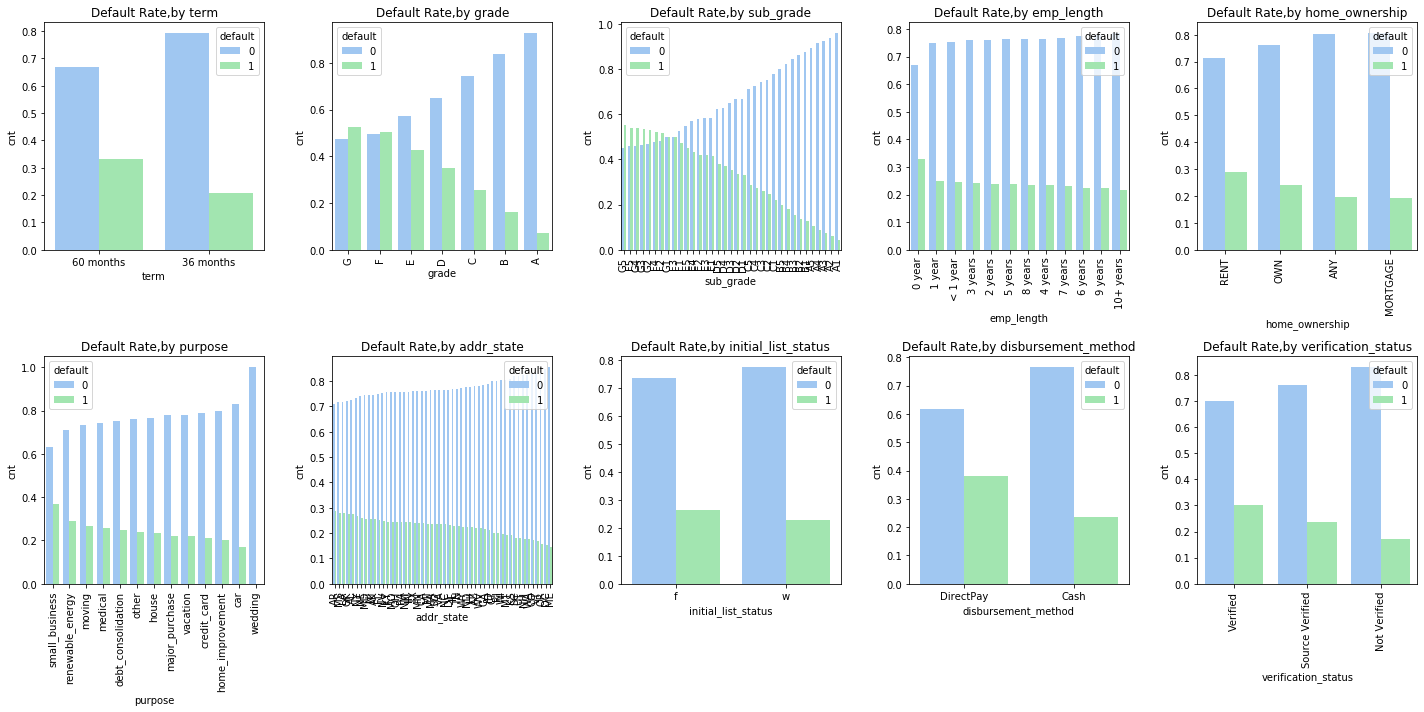

In [68]:
nrow,ncol = 2,5 
plt.figure(figsize=(20,10))
for i in np.arange(nrow*ncol):
    plt.subplot(nrow,ncol,i+1)
    pred_by_default(df_7,cat_col[i],'cat')
     
plt.tight_layout()
plt.show()

*Findings*
- The trend is clear in each graph that for certain levels of the variable are associated with higher default rate, which means the varaible has explanatroy power 

### 6.2 Numerical  Variables

In [69]:
num_col = df_7.loc[:,df_7.columns !='default'].select_dtypes(exclude=[object]).columns.values

In [70]:
df_7[num_col].describe()

,loan_amnt,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,...,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,mths_since_recent_inq,mo_sin_old_il_acct,mths_since_recent_bc_dlq,mths_since_earliest_cr,fico_range_avg
count,333312.000000,333312.00000,333312.000000,3.333120e+05,333312.000000,333312.000000,333312.000000,333312.000000,333312.000000,333312.000000,...,333312.000000,3.333120e+05,3.333120e+05,3.333120e+05,3.333120e+05,333312.000000,333312.000000,333312.000000,333312.000000,333312.000000
mean,14287.106075,13.60317,440.495254,7.989100e+04,18.242939,0.337036,0.615114,-462.430687,-781.988617,11.862087,...,0.064534,1.820225e+05,5.203784e+04,2.254354e+04,4.533959e+04,-80.268325,97.775580,-741.329259,247.087132,698.644374
std,9040.702023,5.33107,278.918138,7.868030e+04,8.521465,0.918998,0.897886,516.555122,429.992894,5.755603,...,0.423832,1.848374e+05,4.996652e+04,2.229097e+04,4.502209e+04,282.284099,179.910937,448.535572,90.680386,32.801841
min,1000.000000,5.32000,30.120000,2.400000e+03,0.000000,0.000000,0.000000,-999.000000,-999.000000,1.000000,...,0.000000,3.000000e+02,0.000000e+00,0.000000e+00,0.000000e+00,-999.000000,-999.000000,-999.000000,73.000000,662.000000
25%,7200.000000,9.75000,237.060000,4.900000e+04,11.860000,0.000000,0.000000,-999.000000,-999.000000,8.000000,...,0.000000,5.306300e+04,2.170275e+04,8.200000e+03,1.661700e+04,1.000000,93.000000,-999.000000,187.000000,672.000000
50%,12000.000000,12.79000,366.980000,6.800000e+04,17.750000,0.000000,0.000000,4.000000,-999.000000,11.000000,...,0.000000,1.196135e+05,3.896200e+04,1.590000e+04,3.454100e+04,4.000000,128.000000,-999.000000,228.000000,692.000000
75%,20000.000000,16.02000,588.565000,9.500000e+04,24.310000,0.000000,1.000000,32.000000,-999.000000,15.000000,...,0.000000,2.615552e+05,6.585425e+04,2.930000e+04,6.069825e+04,9.000000,151.000000,-999.000000,293.000000,717.000000
max,40000.000000,30.99000,1719.830000,9.550000e+06,49.960000,25.000000,5.000000,192.000000,121.000000,88.000000,...,46.000000,9.999999e+06,3.408095e+06,1.105500e+06,2.000000e+06,25.000000,999.000000,162.000000,1036.000000,847.500000


Plot some variables thar investors might be interested in when choosing notes:
- loan amount and interst rate to access the investment potential earnings 
- borrower's fico score, number of deliq in 2 years, debt to credit ratio, and annual income to access borrowers solvency

In [71]:
num_col_toplt = ['loan_amnt','int_rate',  'fico_range_avg',  'dti','annual_inc','delinq_2yrs']

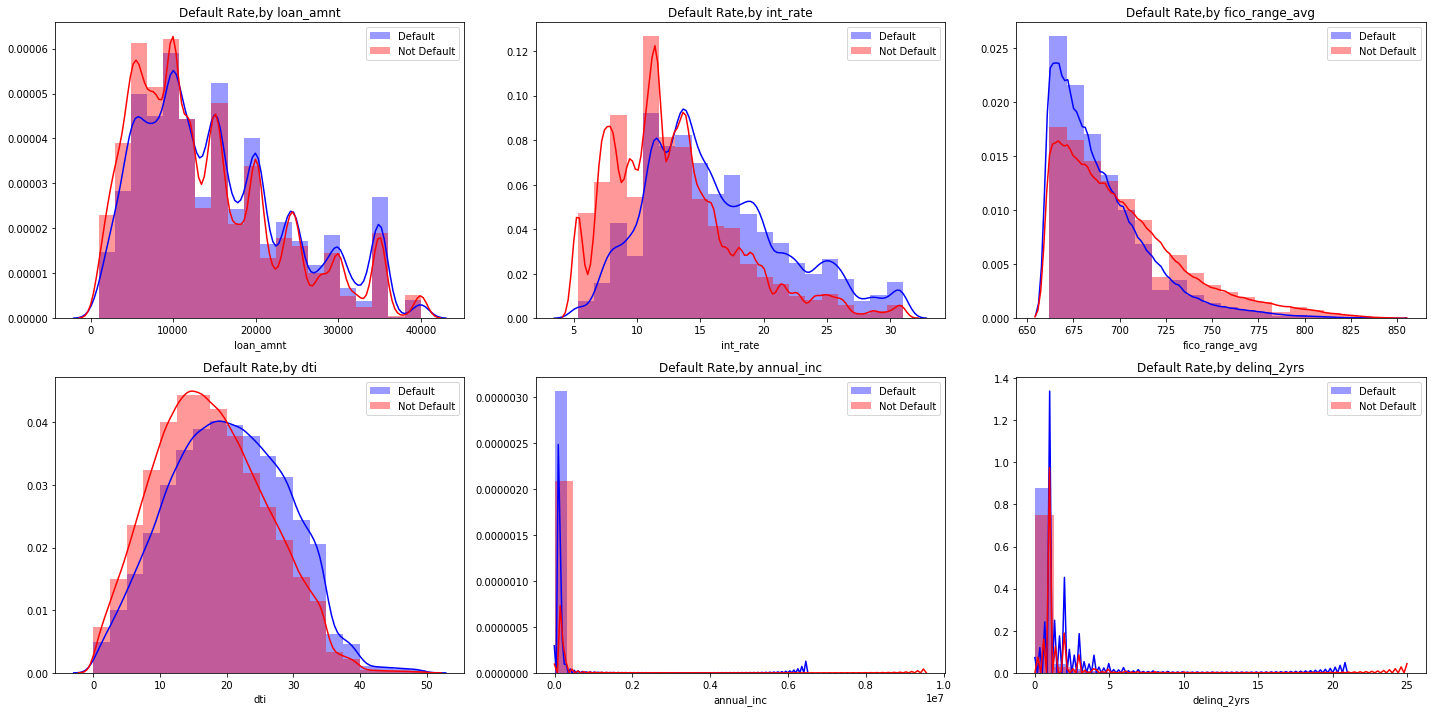

In [72]:
nrow , ncol =2, 3 
plt.figure(figsize=(20,10))
for i in np.arange(nrow*ncol):
    plt.subplot(nrow,ncol,i+1)
    pred_by_default(df_7,num_col_toplt[i],'cont')
     
plt.tight_layout()
plt.show()

*Some Findings*
- These numerical values are not normally distributed
- The variable's distribution is different for these associated with default loan and those non-default ones. For example, The int_rate, dti, avg fico range for defaulters are higher compare with non-defaulters
- Some variables exist extreme outliers, this will be issue if I am going to employed any parametric method and tree based methods are robust to outliers; but for now, I am going to leave them there for now 

## 7. Check Multicollinearity between predictors

### 7.1 Categorical 
- Apply Cramer's V to examine the association between any two categorical variables
- grade and subgrade are found to be highly correlated and since subgrade has above 30 types, dopt this field

In [73]:
for comb in np.array(list(combinations(cat_col, 2))):
    table, results = rp.crosstab(df_7[comb[0]], df_7[comb[1]],  test= 'chi-square')
    if results.iloc[2,1] >= 0.9: 
        print(comb)

['grade' 'sub_grade']


In [74]:
# drop sub_grade from datasets 
df_8 = df_7.drop(['sub_grade'], axis =1).copy()

### 7.2 Numerical 
- plot the correlation matrix
- check linear correlation between two  variables: consider correlation > 0.7 or < -0.5 to be highly correlated variables = > remove these to reduce multicolinarity
- first feature from each highly correlated feature pair is removed

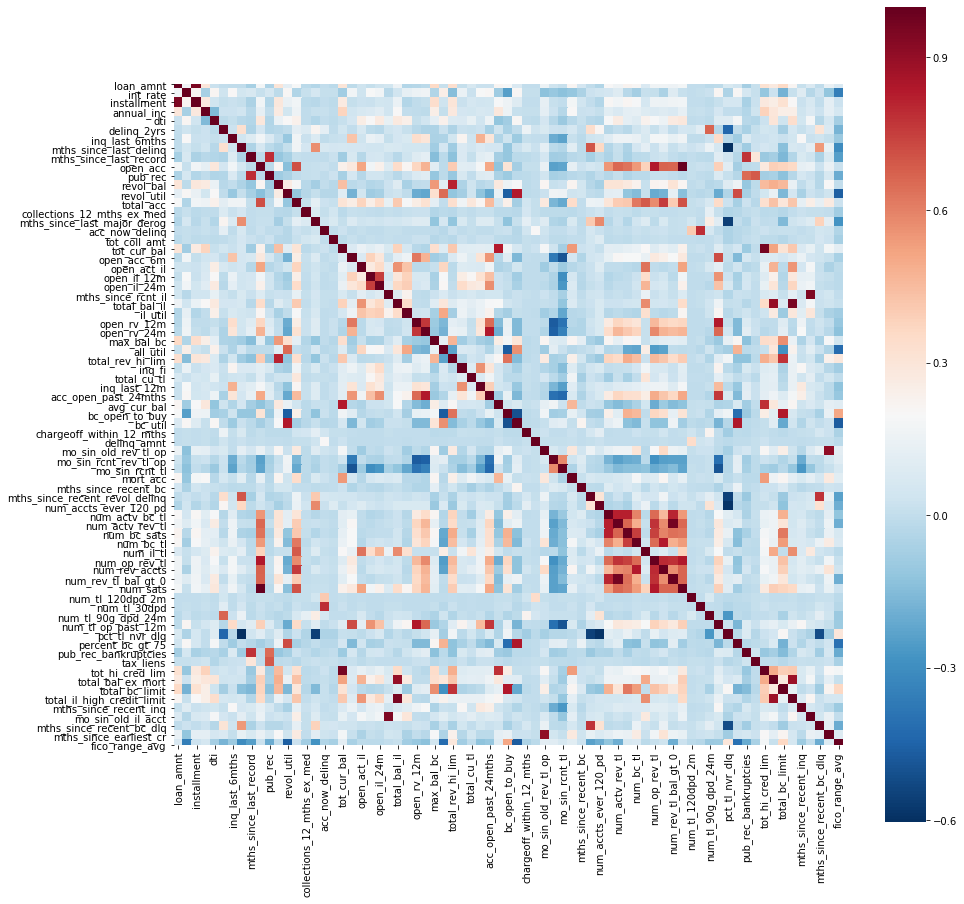

In [75]:
corrs = df_8[num_col].corr()
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(corrs, square=True, cmap="RdBu_r")
plt.show()

In [76]:
comb_num_col = np.array(list(combinations(num_col, 2)))
corr_num_col = np.array([])
for comb in comb_num_col:
    corr = stats.pearsonr(df_8[comb[0]], df_8[comb[1]])[0]
    corr_num_col = np.append(corr_num_col, corr)
high_corr_col = comb_num_col[(np.where((corr_num_col >= 0.7) | (corr_num_col < -0.5)))]

In [122]:
df_9 = df_8.drop(np.unique(np.unique(high_corr_col[:, 0])), axis=1).copy()

### 8.  Categorical Variable Regroup and encode 
- variables like grade, state, and purpose have lot of levels, so I would like to see if I can manually reduce its levels 
- encode grade using lable encoding 

In [123]:
df_9.select_dtypes(include=[object]).describe()

,term,grade,emp_length,home_ownership,purpose,addr_state,initial_list_status,disbursement_method,verification_status
count,333312,333312,333312,333312,333312,333312,333312,333312,333312
unique,2,7,12,4,13,50,2,2,3
top,36 months,C,10+ years,MORTGAGE,debt_consolidation,CA,w,Cash,Source Verified
freq,257594,102767,113736,164010,191116,47817,250294,331160,138992


#### 8.1 addr_state 
- There are 50 states in total and there are the default rate varies for each state; Using OH encoding will introduced lots of new columns
- One thing I came up with is to convert this info into *regions* 
- The default rate differs from one region to another, although it doesn't varies as significantly as it was with state
- So this gives me incentive to encode state value by region and thus reduced to 4 levels 

In [124]:
default_by_state =(df_9.groupby(['addr_state'])['default']
                     .value_counts(normalize=True)
                     .mul(100)
                     .reset_index(name = 'Percent')     
                     .sort_values(['Percent'], ascending = [ False]))
default_state_rt = default_by_state.loc[default_by_state.default == 1, ['addr_state', 'Percent']].reset_index( drop = True)
default_state_rt.iloc[np.r_[0:3, -3:0]]

,addr_state,Percent
0,AR,28.907836
1,MS,28.128079
2,LA,28.080537
47,OR,15.742397
48,DC,15.223097
49,ME,14.529058


In [125]:
# Considering to Categorize all states into regions 
midwest = [ 'IL', 'IN', 'KS', 'MI', 'MN', 'MO', 'ND', 'NE', 'OH', 'SD', 'WI']
northeast = ['CT', 'MA', 'ME', 'NH', 'NJ', 'NY', 'PA', 'RI', 'VT']
south = ['AL', 'AR', 'DC', 'DE', 'FL', 'GA', 'KY', 'LA', 'MD', 'MS', 'NC', 'OK', 'SC', 'TN', 'TX', 'VA', 'WV']
west = ['AK', 'AZ', 'CA', 'CO', 'HI', 'ID', 'MT', 'NM', 'NV', 'OR', 'UT', 'WA', 'WY']
region_dct = {}
region_dct["MW"] = midwest
region_dct["NE"] = northeast
region_dct["S"] = south
region_dct["W"] = west

In [126]:
region_lst = []
for x in df_9.addr_state:
    for k,v in region_dct.items():
        if v.count(x) > 0:
            region_lst.append(k)
df_9['addr_region'] = region_lst
df_9['addr_region'] = df_9['addr_region'].astype('category')

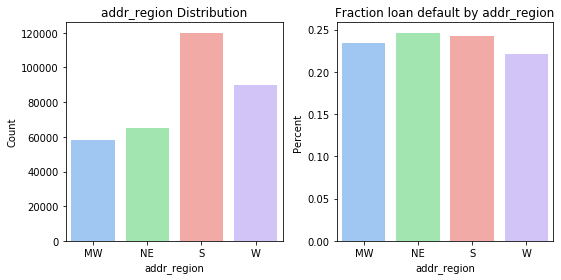

In [127]:
univariate_plot(df_9,'addr_region','cat') 
# Most of loan applicant live in south region, while most applicants live in Northease region are mostly likely to default 

In [128]:
# drop addr_state
df_10 = df_9.drop(['addr_state'],axis =1 )

#### 8.2  employment length   
- reduced from 12 levels to 5 levels by combine some of levels together 
- Visible from plot, the regroup should be 0 year ,  <= 1 year , 2- 5 year, 5- 8 year, 8 - 10+  year as to preserve the distribution of default rate among these groups 

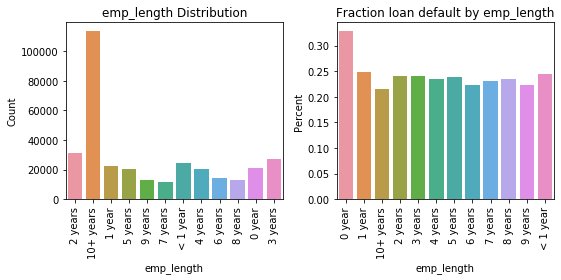

In [129]:
univariate_plot(df_10, 'emp_length', 'cat')

In [130]:
# replace old levels with new levels 
emp_dict = {
"10+ years":'8-10+ years',
"9 years": '8-10+ years',
"8 years": '8-10+ years',
"7 years": "5-8 years",
"6 years": "5-8 years",
"5 years": "5-8 years",
"4 years":"2-5 years",
"3 years":"2-5 years",
"2 years": "2-5 years",
"1 year": "1 year or less",
"< 1 year": "1 year or less",
"0 year":"Never"}
df_10 = df_10.replace({"emp_length": emp_dict}) 
df_10['emp_length'] = df_10['emp_length'].astype('category')

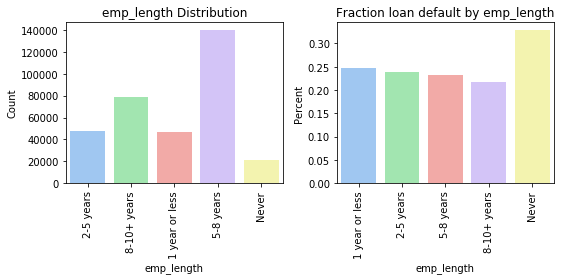

In [131]:
univariate_plot(df_10, 'emp_length', 'cat')

#### 8.3   purpose 
- wedding has only one observation, not so informative
- with 12 levels, may try target encoding

In [132]:
df_10.purpose.value_counts()

debt_consolidation    191116
credit_card           64912 
home_improvement      25553 
other                 23208 
major_purchase        8350  
medical               4599  
car                   3929  
small_business        3602  
vacation              2927  
moving                2813  
house                 2040  
renewable_energy      262   
wedding               1     
Name: purpose, dtype: int64

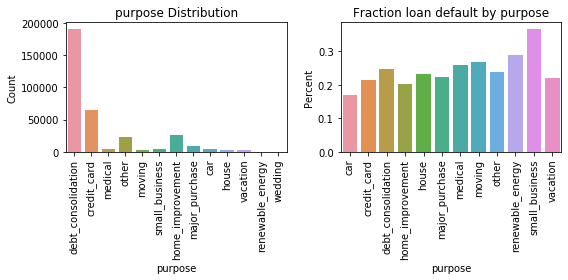

In [133]:
univariate_plot(df_10, 'purpose', 'cat')
# The most purpose of making loan is "debt consolidation" and the small bussiness loan associated with highest default 

In [134]:
# with only one row related with wedding, this purpose is off interest, drop the row 
df_10 = df_10.loc[df_10.purpose != 'wedding', : ].copy()

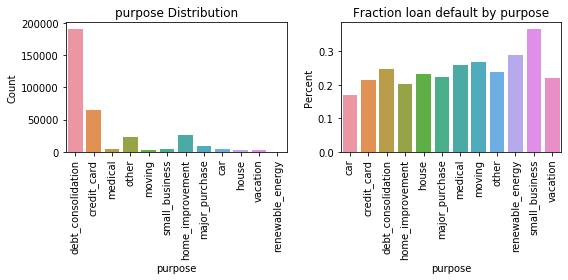

In [135]:
univariate_plot(df_10, 'purpose', 'cat')

#### 8.4  grade

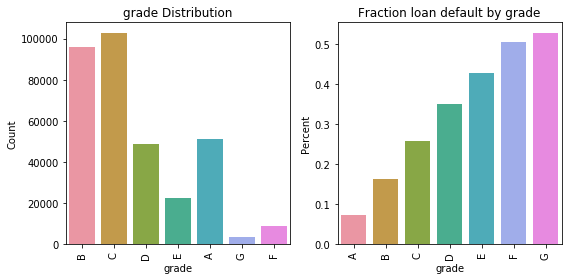

In [136]:
univariate_plot(df_10, 'grade', 'cat')

In [137]:
grade_dict = {
"A": 1,
"B": 2,
"C": 3,
"D": 4,
"E": 5,
"F": 6,
"G": 7
}
df_10.grade = df_10.grade.replace( grade_dict)

In [140]:
dt_to_save = df_10.copy()
dt_to_save.to_csv("train_data.csv",index=False)